In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import os
sns.set(style="white")

In [38]:
FIG_PATH = "./figure/"
espl = pd.read_pickle("espl.pkl")
y = pd.read_pickle("./y-2s.pkl")

In [39]:
espl.head()

,maxA,MVDeriv,meanA,Var,Med,Min
0,17.920838,0.001170,9.661280,13.439433,8.559716,4.398184
1,19.667330,0.001723,10.383013,15.650140,9.920799,4.514995
2,19.205382,0.001222,10.253074,16.677828,9.632026,3.373946
3,19.026058,0.001365,10.073228,14.020140,9.310040,5.057207
4,17.863954,0.001457,10.640028,16.545959,10.268722,3.569632


In [40]:
from funzioni import indice_gini, tasso_errata_classificazione, MatriceConfusione

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

In [42]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

Accuratezza DecisionTreeClassifier(): 84.84%


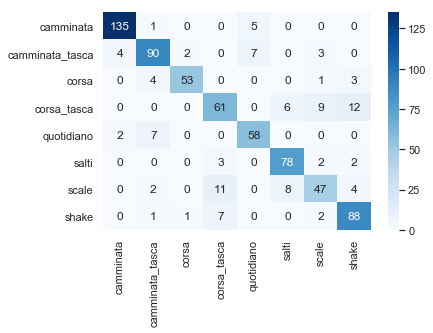

In [43]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42,criterion='entropy'))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
MatriceConfusione(y_val, y_pred)
plt.show()

Pipeline(memory=None,
     steps=[('tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [44]:
dot_data = export_graphviz(
    decision_tree=dtc.named_steps["tree"], 
    feature_names=espl.columns,
    
    filled=True,
    rounded=True,
    node_ids=None
)
#display(graphviz.Source(dot_data))

In [45]:
print("Profondità dell'albero allenato senza restrizioni: {}".format(dtc.named_steps["tree"].tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(X_train) // 2))

Profondità dell'albero allenato senza restrizioni: 15
Massimo numero minimo di osservazioni in una foglia: 1077


In [46]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [47]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, dtc.named_steps["tree"].tree_.max_depth),
    'tree__min_samples_leaf': 2 ** np.arange(10),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'tree__min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)}]


In [49]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|████████████████████████████████████████| 140/140 [00:03<00:00, 40.10it/s]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.8637,8,2
1,0.8637,11,4
2,0.8637,12,4
3,0.8637,13,4
4,0.8637,14,4


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
135,0.318498,1,32
136,0.318498,1,64
137,0.318498,1,128
138,0.318498,1,256
139,0.318498,1,512


In [56]:
from funzioni import grafico_metrica_iperparametro
from funzioni import grafico_metrica_iperparametri
from sklearn.impute import SimpleImputer

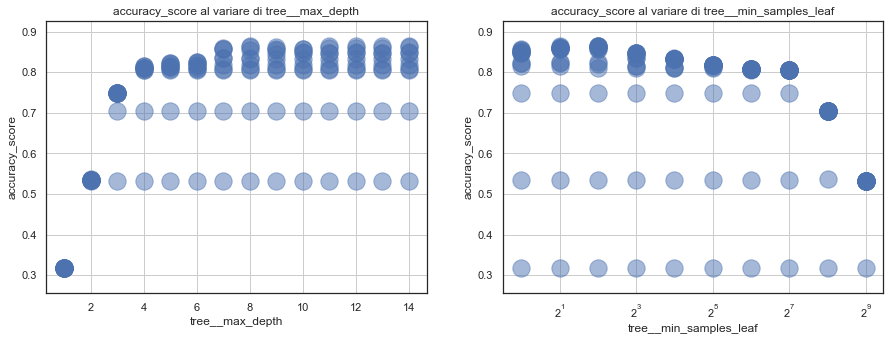

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "tree__max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "tree__min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

#probabilmente una profondità massima di 4 e un numero minimo di unità per foglia pari a 4 o 8 sono sufficienti
#(vedi tabella risultati prime due righe)

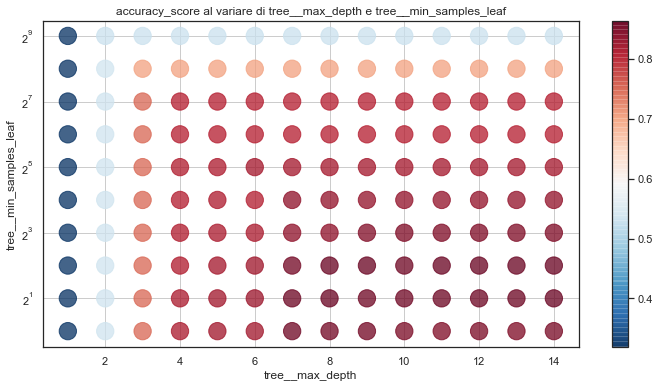

In [55]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "tree__max_depth", "tree__min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [57]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))

In [58]:
print("profondità ottimale:",max_depth)
print("numero ottimale minimo di unità per foglia:",min_samples_leaf)
risultati.head(12)

profondità ottimale: 8
numero ottimale minimo di unità per foglia: 2


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.863700,8,2
1,0.863700,11,4
2,0.863700,12,4
3,0.863700,13,4
4,0.863700,14,4
5,0.862309,8,4
6,0.862309,9,4
7,0.862309,14,2
8,0.860918,11,2
9,0.860918,12,2


In [64]:
dot_data = export_graphviz(
    decision_tree=dtc_tun.named_steps["tree"],
    feature_names=espl.columns,
    filled=True,
    rounded=True,
    node_ids=None
)
#display(graphviz.Source(dot_data))

Accuratezza DecisionTreeClassifier(): 84.8%
Accuratezza DecisionTreeClassifier(max_depth=8, min_samples_leaf=2): 84.8%


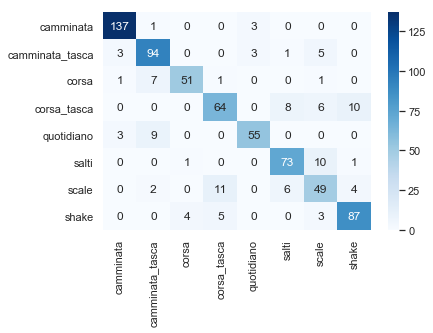

<Figure size 432x288 with 0 Axes>

In [61]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))
MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

In [62]:
from funzioni.grafici import grafico_importanza_variabili
from funzioni import MatriceConfusione

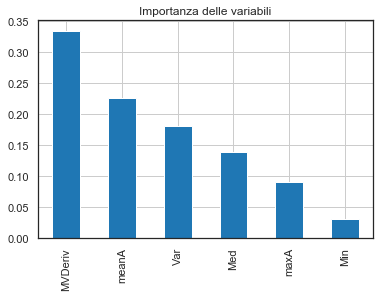

In [63]:
importanze = dtc_tun.named_steps["tree"].feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()